## Installation of the required libraries


In [1]:
!pip install findspark
!pip install xlrd
!pip install scikit-learn
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# needed in colab, remove this cell when executing on VMs
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 16.0 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=234fbdab84974db643573c724c4789de5614e7f02003e73aadb7d2512d890922
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


## Import of the libraries


In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn.metrics import classification_report
%matplotlib inline

import findspark
#findspark.init()
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import StructType,\
                              StructField,\
                              IntegerType,\
                              DoubleType,\
                              StringType
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.classification import LogisticRegression

## Loading block
The following block is needed to load the dataset from the excel file,
create the current spark session, build the pyspark dataframe containing
the data and show its the schema.

In [4]:
credit = pd.read_excel('./default of credit card clients.xls', header=1)


spark = SparkSession.builder.master("local[1]").appName("SparkByExamples.com").getOrCreate()

credit_schema = StructType([\
    StructField("ID", IntegerType(), False),
    StructField("LIMIT_BAL", IntegerType(), False),
    StructField("SEX", IntegerType(), False),
    StructField("EDUCATION", IntegerType(), False),
    StructField("MARRIAGE", IntegerType(), False),
    StructField("AGE", IntegerType(), False),
    StructField("PAY_0", IntegerType(), False),
    StructField("PAY_2", IntegerType(), False),
    StructField("PAY_3", IntegerType(), False),
    StructField("PAY_4", IntegerType(), False),
    StructField("PAY_5", IntegerType(), False),
    StructField("PAY_6", IntegerType(), False),
    StructField("BILL_AMT1", IntegerType(), False),
    StructField("BILL_AMT2", IntegerType(), False),
    StructField("BILL_AMT3", IntegerType(), False),
    StructField("BILL_AMT4", IntegerType(), False),
    StructField("BILL_AMT5", IntegerType(), False),
    StructField("BILL_AMT6", IntegerType(), False),
    StructField("PAY_AMT1", IntegerType(), False),
    StructField("PAY_AMT2", IntegerType(), False),
    StructField("PAY_AMT3", IntegerType(), False),
    StructField("PAY_AMT4", IntegerType(), False),
    StructField("PAY_AMT5", IntegerType(), False),
    StructField("PAY_AMT6", IntegerType(), False),
    StructField("default payment next month", IntegerType(), False)])

spark_credit= spark.createDataFrame(credit, schema = credit_schema)
spark_credit.printSchema()

root
 |-- ID: integer (nullable = false)
 |-- LIMIT_BAL: integer (nullable = false)
 |-- SEX: integer (nullable = false)
 |-- EDUCATION: integer (nullable = false)
 |-- MARRIAGE: integer (nullable = false)
 |-- AGE: integer (nullable = false)
 |-- PAY_0: integer (nullable = false)
 |-- PAY_2: integer (nullable = false)
 |-- PAY_3: integer (nullable = false)
 |-- PAY_4: integer (nullable = false)
 |-- PAY_5: integer (nullable = false)
 |-- PAY_6: integer (nullable = false)
 |-- BILL_AMT1: integer (nullable = false)
 |-- BILL_AMT2: integer (nullable = false)
 |-- BILL_AMT3: integer (nullable = false)
 |-- BILL_AMT4: integer (nullable = false)
 |-- BILL_AMT5: integer (nullable = false)
 |-- BILL_AMT6: integer (nullable = false)
 |-- PAY_AMT1: integer (nullable = false)
 |-- PAY_AMT2: integer (nullable = false)
 |-- PAY_AMT3: integer (nullable = false)
 |-- PAY_AMT4: integer (nullable = false)
 |-- PAY_AMT5: integer (nullable = false)
 |-- PAY_AMT6: integer (nullable = false)
 |-- default 

## Pre-processing
The following block is needed to drop the "ID" column, remove duplicate examples and outliers

In [5]:
spark_credit = spark_credit.drop('ID')
spark_credit = spark_credit.distinct()
spark_credit = spark_credit.where(col('LIMIT_BAL') <= 550000 ).where(col('PAY_AMT6') <= 50000)

## Splitting of the dataset

In [6]:
train_cred, test_cred = spark_credit.randomSplit([0.7, 0.3], seed = 1234)

## Standardization of the features
The following block is needed to assemble the previously created DataFrames and scale all the features by using the StandardScaler provided in spark.ml.feature.

In [7]:
col_list = [spark_credit.dtypes[i][0] for i in range(0, len(spark_credit.dtypes)-1)]
credit_vec_ass = VectorAssembler(inputCols = col_list, outputCol = "temp_features")

credit_assembled = credit_vec_ass.transform(spark_credit)
train_assembled = credit_vec_ass.transform(train_cred)
test_assembled = credit_vec_ass.transform(test_cred)

# in "Scaled" there will be values scaled with the corrected sample standard deviation,
# instead of the population-based standard deviation
spark_scaler = StandardScaler(withMean=True, withStd=True, inputCol="temp_features", outputCol="scaled")
fitted_scaler = spark_scaler.fit(dataset = credit_assembled)
scaled_data = fitted_scaler.transform(credit_assembled)
scaled_train = fitted_scaler.transform(train_assembled)
scaled_test = fitted_scaler.transform(test_assembled)

vectorized_scaled_data = scaled_data.select(["scaled", "default payment next month"])
vectorized_scaled_train = scaled_train.select(["scaled", "default payment next month"])
vectorized_scaled_test = scaled_test.select(["scaled", "default payment next month"])
print(vectorized_scaled_data.show())
print(vectorized_scaled_train.show())
print(vectorized_scaled_test.show())

+--------------------+--------------------------+
|              scaled|default payment next month|
+--------------------+--------------------------+
|[0.61459469682298...|                         0|
|[0.53457136090135...|                         0|
|[0.53457136090135...|                         0|
|[-0.9058486856880...|                         0|
|[0.45454802497971...|                         0|
|[-0.5857553420015...|                         0|
|[1.57487472788257...|                         0|
|[-0.5857553420015...|                         0|
|[-0.7458020138447...|                         0|
|[-0.1856386623933...|                         1|
|[-0.1056153264717...|                         1|
|[-0.1056153264717...|                         0|
|[1.09473471235277...|                         0|
|[-1.1459186934529...|                         0|
|[-0.9058486856880...|                         1|
|[0.85466470458788...|                         0|
|[0.05443134537155...|                         0|


In [14]:
def plot_cumulative_gains(y_true, y_probs):
  """
  Function to plot the cumulative gains chart.
  It plots the cumulative number of positive predictions made,
  as function of the total number of positive preditcions

  Params:
    y_true: an array of length num_examples containing the ground truth labels
    y_probs: the probabilities associated for each example
             to each label, it is an array of shape (num_examples, num_classes)  
  """
  skplt.metrics.plot_cumulative_gain(y_true, y_probs)
  plt.xlabel("Number of observations")
  plt.ylabel("Cumulative number of true positive predictions")
  plt.title("Cumulative Gains Chart")
  plt.show()

## Construction and fitting of the Logistic Regression classifier from spark.ml.classification

In [15]:
blor = LogisticRegression(featuresCol="scaled", labelCol="default payment next month", regParam = 0.01, maxIter = 10)
blorModel = blor.fit(vectorized_scaled_train)

## Evaluation of the classifier
The cell below is needed to compute the performances of the classifier that has been fitted, in this case the "collect()" is a valid operation since it is performed on the test set only.

              precision    recall  f1-score   support

           0       0.81      0.98      0.89      6841
           1       0.71      0.21      0.32      1967

    accuracy                           0.80      8808
   macro avg       0.76      0.59      0.60      8808
weighted avg       0.79      0.80      0.76      8808



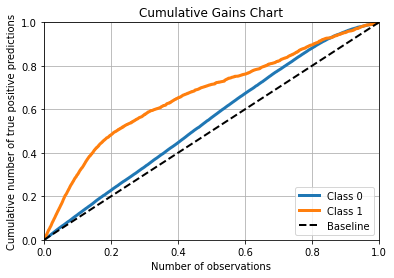

In [16]:
Y_true = vectorized_scaled_test.select("default payment next month").collect()
test_cred_no_def = vectorized_scaled_test.select("scaled")
Y_pred_df = blorModel.transform(test_cred_no_def)
Y_pred_probabilities = Y_pred_df.select("probability").collect()
Y_pred_predictions = Y_pred_df.select("prediction").collect()

Y_pred_probabilities_np = np.array(Y_pred_probabilities)
Y_pred_probabilities_np = np.reshape(Y_pred_probabilities_np, (Y_pred_probabilities_np.shape[0], 2))

print(classification_report(Y_true, Y_pred_predictions))
plot_cumulative_gains(np.array(Y_true), Y_pred_probabilities_np)